In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

In [2]:
# Helper function
def hours_to_seconds(hours):
    return hours * 3600

In [3]:
# Caluclate how many samples to include per file
# The sample rate should match the code on your temperature monitor
sample_rate = 0.2   # Hz
sample_time = 1     # Hours
samples_per_file = sample_rate * hours_to_seconds(sample_time)

In [7]:
# Path to the dataset from Adafruit.io
# Change <DATASET-NAME> to the file name of the Adafruit.io data you downloaded.
dataset_path = './dataset/raw/ms_temperature-20200810-1730.csv'

# Load the dataset using pandas
df = pd.read_csv(dataset_path, usecols=[1,3], parse_dates=['created_at'])

df

,value,created_at
0,-9.0000,2020-08-05 22:46:05+00:00
1,-9.1875,2020-08-05 22:46:10+00:00
2,-9.2500,2020-08-05 22:46:15+00:00
3,-9.3750,2020-08-05 22:46:20+00:00
4,-9.5000,2020-08-05 22:46:25+00:00
...,...,...
79842,-13.8750,2020-08-10 17:30:27+00:00
79843,-13.8125,2020-08-10 17:30:32+00:00
79844,-13.7500,2020-08-10 17:30:38+00:00
79845,-13.7500,2020-08-10 17:30:43+00:00


In [ ]:
# You may want to trim start and end of your data. Espcially if the data at the start of the set is from outside the freezer or while the thermocouple was cooling down.

start_time_trim = 1 # Hours
end_time_trim = 1   # Hours
start_time = hours_to_seconds(start_time_trim)
end_time = len(df.index) - hours_to_seconds(end_time_trim)

df = df.truncate(before=start_time, after=end_time)

# Create one file for each group of samples
arr = []
for i, temp in df.iterrows():
    # starting_idx = i
    arr.append(temp)
    if i % samples_per_file == 0 and i != start_time:
        sample = pd.DataFrame(data=arr)
        sample.to_csv('./dataset/training/output_'+str(i), index=False, header=False)
        arr = []

In [4]:
def get_value_from_df(df):
    return df.value.to_list()

In [5]:
def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std

In [8]:
training_value = get_value_from_df(df)

In [9]:
training_value, training_mean, training_std = normalize(training_value)
len(training_value)

79847

In [10]:
def create_sequences(values, time_steps=int(samples_per_file)):
    output=[]
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.expand_dims(output, axis=2)

In [11]:
x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (79127, 720, 1)


In [14]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(x_train.shape[1], activation="sigmoid"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 720, 32)           64        
_________________________________________________________________
dense_7 (Dense)              (None, 720, 16)           528       
_________________________________________________________________
dense_8 (Dense)              (None, 720, 8)            136       
_________________________________________________________________
dense_9 (Dense)              (None, 720, 16)           144       
_________________________________________________________________
dense_10 (Dense)             (None, 720, 32)           544       
_________________________________________________________________
dense_11 (Dense)             (None, 720, 720)          23760     
Total params: 25,176
Trainable params: 25,176
Non-trainable params: 0
__________________________________________________

In [12]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 360, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 360, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 180, 16)           3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 360, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 360, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 720, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 720, 1)            2

In [15]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
557/557 [==============================] - 518s 931ms/step - loss: 0.6561 - val_loss: 0.4477
Epoch 2/50
557/557 [==============================] - 564s 1s/step - loss: 0.5860 - val_loss: 0.4474
Epoch 3/50
557/557 [==============================] - 606s 1s/step - loss: 0.5859 - val_loss: 0.4474
Epoch 4/50
557/557 [==============================] - 611s 1s/step - loss: 0.5859 - val_loss: 0.4474
Epoch 5/50
557/557 [==============================] - 1923s 3s/step - loss: 0.5858 - val_loss: 0.4474
Epoch 6/50
557/557 [==============================] - 503s 902ms/step - loss: 0.5858 - val_loss: 0.4474
Epoch 7/50
 89/557 [===>..........................] - ETA: 2:03:08 - loss: 0.5854

KeyboardInterrupt: 

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

NameError: name 'history' is not defined

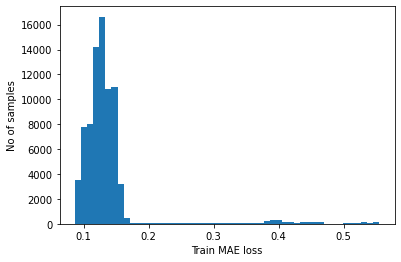

Reconstruction error threshold:  0.5548054789308737


In [15]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

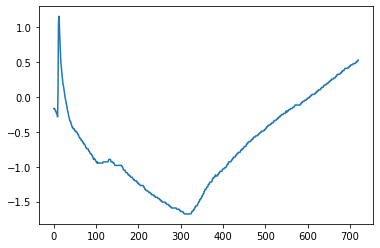

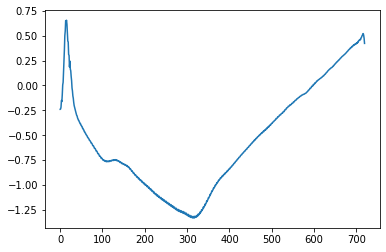

In [19]:
plt.plot(x_train[112])
plt.show()
plt.plot(x_train_pred[112])
plt.show()

In [29]:
# Path to the dataset from Adafruit.io
# Change <DATASET-NAME> to the file name of the Adafruit.io data you downloaded.
dataset_path = './dataset/raw/known_anomaly.csv'

# Load the dataset using pandas
df_test = pd.read_csv(dataset_path, usecols=[1,3], parse_dates=['created_at'])

df_test

,value,created_at
0,-10.9375,2020-08-12 17:05:31+00:00
1,-10.9375,2020-08-12 17:05:36+00:00
2,-10.9375,2020-08-12 17:05:41+00:00
3,-10.9375,2020-08-12 17:05:46+00:00
4,-10.8750,2020-08-12 17:05:51+00:00
...,...,...
1949,-9.3125,2020-08-12 19:53:43+00:00
1950,-9.3125,2020-08-12 19:53:48+00:00
1951,-9.3125,2020-08-12 19:53:53+00:00
1952,-9.2500,2020-08-12 19:53:59+00:00


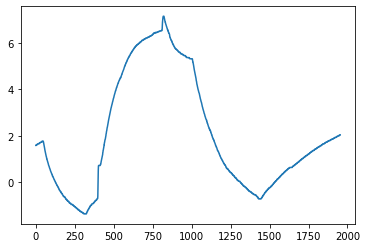

Test input shape:  (1234, 720, 1)


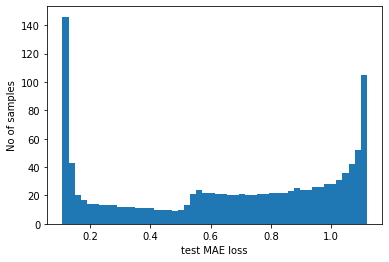

Number of anomaly samples:  786
Indices of anomaly samples:  (array([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
  

In [37]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_test)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\adazulay\AppData\Local\Temp\tmpumx78jjr\assets


In [ ]:
# Create an array of file names in directory
samples_in_dir = listdir('./dataset/training')
# Join the path and file name for all files in dicrectory
samples_in_dir = [join('./dataset/training', sample) for sample in samples_in_dir]

In [ ]:
# Set the size of the validation set to 20%
val_size = int(.2 * len(samples_in_dir))

# Randomize the samples
np.random.shuffle(samples_in_dir)

# Split data into training samples and validation samples
val_samples = samples_in_dir[:val_size]
train_samples = samples_in_dir[val_size:]

# Check that the data split correctly
assert(len(val_samples) + len(train_samples) == len(samples_in_dir))

In [ ]:
def extract_features(sample):
    features = []

    # Median absolute deviation (MAD)
    mad = sp.stats.median_absolute_deviation(sample)

    features.append(mad)
    return np.array(features).flatten()

In [ ]:
# Function: loop through filenames, creating feature sets
def create_feature_set(filenames):
    x_out = []
    for file in filenames:
        sample = np.loadtxt(file)
        features = extract_features(sample)
        x_out.append(features)
    return np.array(x_out)

In [ ]:
# Extract Features for the training and validation sets
training = create_feature_set(train_samples)
val = create_feature_set(val_samples)